In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from beta_irt.visualization.plots import newline
# from beta_irt.visualization.plots import plot_parameters
# from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import glob
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from beta_irt.visualization.plots import plot_parameters
from scipy.interpolate import spline

from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline
from irt import beta_irt
from beta_irt.visualization.plots import newline

In [12]:
name = 'polynomial'

In [47]:
names = []
path = './Results_IRT/'+name+'/'
foldernames = glob.glob(path+'*/')
keys = list(map(lambda x: int(x[:-1].split('_')[-1]), foldernames))
keys = sorted(range(len(keys)), key=lambda k: keys[k])
foldernames = list(map(lambda k: foldernames[k], keys))
names = list(map(lambda x: x.split('/')[-2], foldernames))
max_std = int(names[-1].split('_')[-1])
cmap1 = sns.cubehelix_palette(rot=-.5,light=1.5,dark=-.5,as_cmap=True)
fsz = 15

In [14]:
foldernames

['./Results_IRT/polynomial/noise_0/',
 './Results_IRT/polynomial/noise_1/',
 './Results_IRT/polynomial/noise_2/',
 './Results_IRT/polynomial/noise_3/',
 './Results_IRT/polynomial/noise_4/',
 './Results_IRT/polynomial/noise_5/',
 './Results_IRT/polynomial/noise_6/',
 './Results_IRT/polynomial/noise_7/',
 './Results_IRT/polynomial/noise_8/',
 './Results_IRT/polynomial/noise_9/',
 './Results_IRT/polynomial/noise_10/',
 './Results_IRT/polynomial/noise_11/',
 './Results_IRT/polynomial/noise_12/',
 './Results_IRT/polynomial/noise_13/',
 './Results_IRT/polynomial/noise_14/',
 './Results_IRT/polynomial/noise_15/',
 './Results_IRT/polynomial/noise_16/',
 './Results_IRT/polynomial/noise_17/',
 './Results_IRT/polynomial/noise_18/',
 './Results_IRT/polynomial/noise_19/']

In [15]:
all_files = []
for i, df in enumerate(foldernames):
    path = df
    filenames = glob.glob(path + "/*.csv")
    
    filenames.sort()

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))
        
    all_files.append(dfs)

In [16]:
filenames

['./Results_IRT/polynomial/noise_19/errors_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/irt_ability_vi_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/irt_data_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/irt_parameters_vi_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/noise_polynomial_s60_f19_sd42.csv',
 './Results_IRT/polynomial/noise_19/test_polynomial_s60_f19_sd42.csv']

In [17]:
all_files[0][-1].shape

(60, 2)

In [18]:
mdls = ['LR', 'Bayes', 'SVR(Linear)', 'SVR(Rbf)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP (100)', 'MLP (50-50)', 'Average', 'Optimal', 'Worst']
abilities = np.zeros((len(mdls), len(foldernames)))
noises = np.zeros((len(foldernames), len(all_files[0][-1])))
errors = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls) - 3))
responses = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls)))
params = np.zeros((len(foldernames), len(all_files[0][-1]), 2))
test = np.zeros((len(foldernames), len(all_files[0][-1]), 2))

In [19]:
for i, data in enumerate(all_files):
    abilities[:, i] = data[1].iloc[:, -1].values
    errors[i] = data[0].values
    responses[i] = data[2].values
    params[i] = data[3].values
    noises[i] = data[-2].values.reshape(1,-1)[0]
    test[i] = data[-1].values

# Noise x MAE

In [20]:
mae = np.zeros((len(all_files), 10))
for i in range(20):
    mae[i] = np.absolute(errors[i]).mean(axis=0)

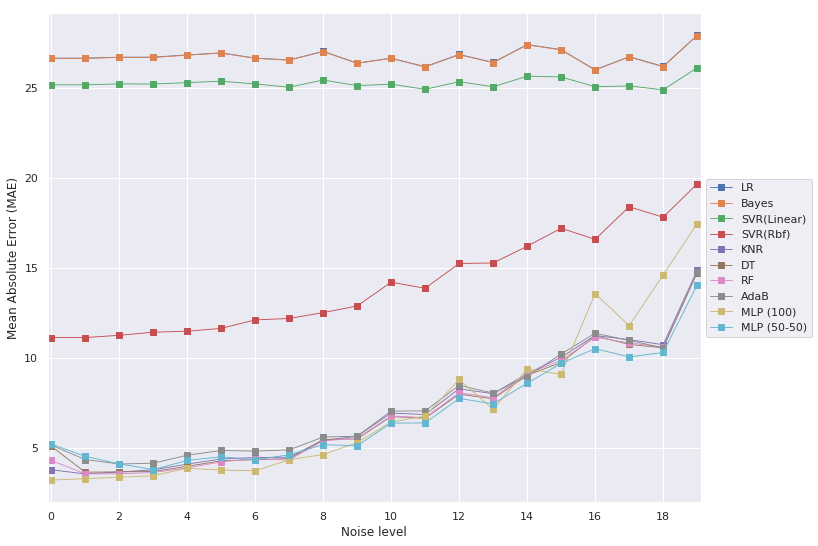

In [24]:
plt.figure(figsize=(18, 9))
for j, model in enumerate(mdls[:10]):
    plt.plot(list(range(20)), mae[:, j], linewidth=0.9, label=model, marker='s',)
plt.xticks(range(0, 20, 2))

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
plt.xlim([-.1,19.1])
legend_x = 1
legend_y = 0.5

plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Noise level')
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.savefig('./Results_IRT/' + name + '/mae_noise.png')

# Noise x Ability

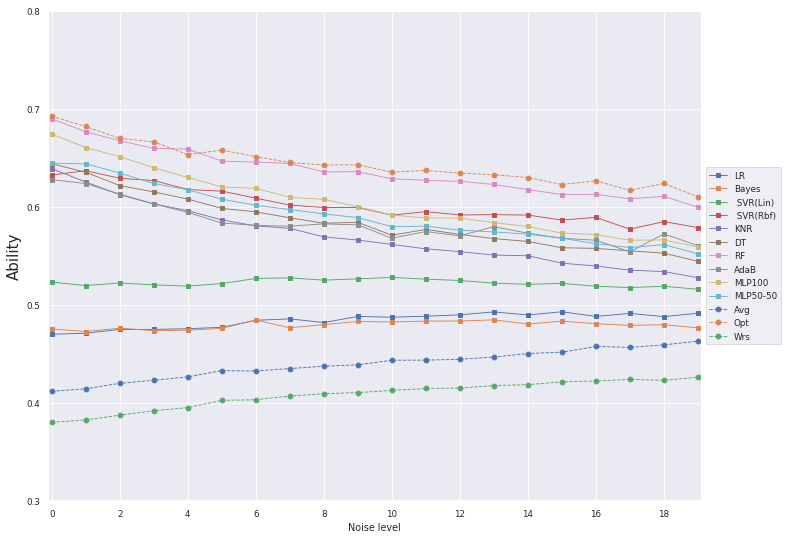

In [53]:
plt.figure(figsize=(18, 9))
for j, model in enumerate(mdls):
    if j>9:
        plt.plot(list(range(20)), abilities[j, :], linewidth=0.9, label=model, marker='o', linestyle = '--')
    else:
        plt.plot(list(range(20)), abilities[j, :], linewidth=0.9, label=model, marker='s')
plt.xticks(range(0, 20, 2))
plt.xlim([-.1,19.1])
plt.ylim([0.3,0.8])

ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
legend_x = 1
legend_y = 0.5

plt.ylabel('Ability', fontsize=fsz)
plt.xlabel('Noise level')
plt.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.savefig('./Results_IRT/' + name + '/noise_ability.png')

# Histograms Responses

In [26]:
plts = ['Original', '50% Noise', '100% Noise']
plot = ['Difficulty', 'Discrimination']
noises_i = [0, 9, 19]

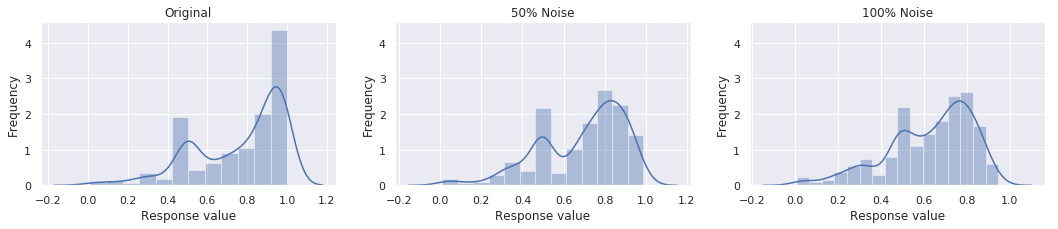

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
scale = 0
for i, noise_i in enumerate(noises_i):
    values = all_files[noise_i][2].values.reshape(-1,1)
    sns.distplot(values, ax= axes[i])
    current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
    if current_scale > scale:
        scale = current_scale
        y_lim = axes[i].get_ylim()
    axes[i].set_title(plts[i])
    axes[i].set_xlabel('Response value')
    axes[i].set_ylabel('Frequency')
for ax in axes:
    ax.set_ylim(y_lim)
fig.savefig('./Results_IRT/'+name+'/hists.png')

# IRT Parameters

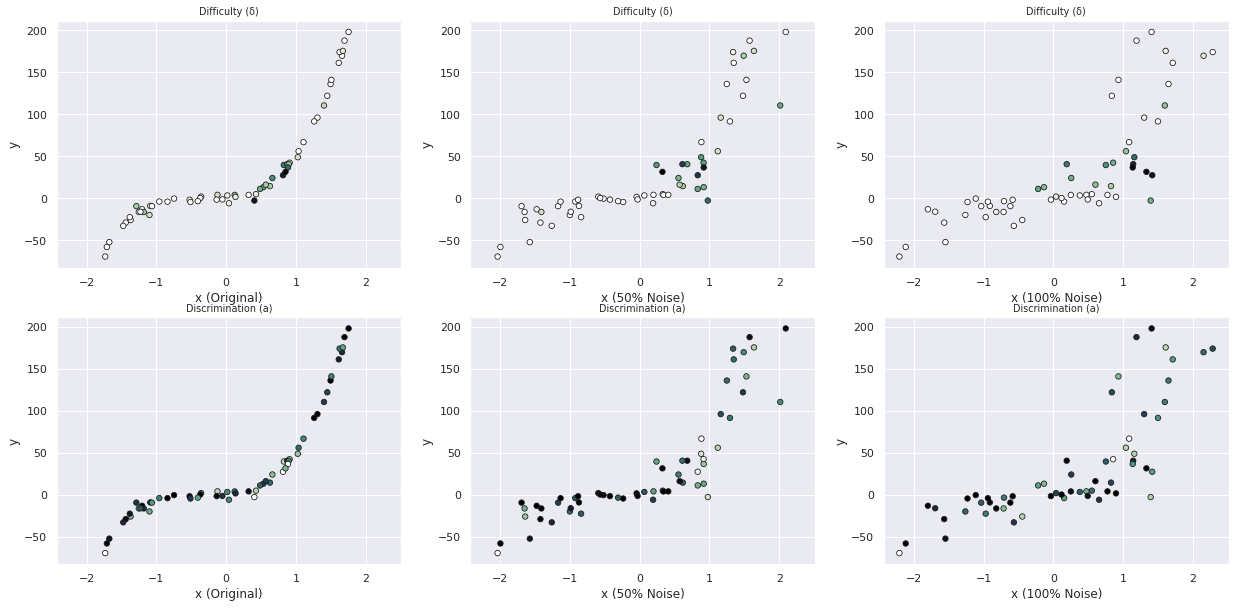

In [28]:
scale = 0
fig, axes = plt.subplots(2, 3, figsize=(21,10))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i):        
        axes[i,j].set_xlim([1.1*test[-1][:, 0].min(), 1.1*test[-1][:, 0].max()])
#         axes[i,j].set_ylim([.85*test[-1][:, 1].min(), 1.15*test[-1][:, 1].max()])    
        
        c = params[noise][:, i]
        
        sns.set_context('paper')

        axes[i, j].scatter(test[noise][:, 0], test[noise][:, 1], c = c, cmap = cmap1, edgecolor='k',s=30)

        axes[i,j].set_xlabel('x (' + plts[j]+')')
        axes[i,j].set_ylabel('y')
        axes[i,j].set_title(title + (' (ẟ)' if i == 0 else ' (a)'))
plt.savefig('./Results_IRT/' + name + '/params_noise.png')

# Difficulty/ Discrimination

In [29]:
Xsort_i = np.argsort(test[0][:, 0].reshape(1,-1))
X_test = test[0][:, 0]
p_mean = params.mean(axis=0)
p_std = params.std(axis=0)

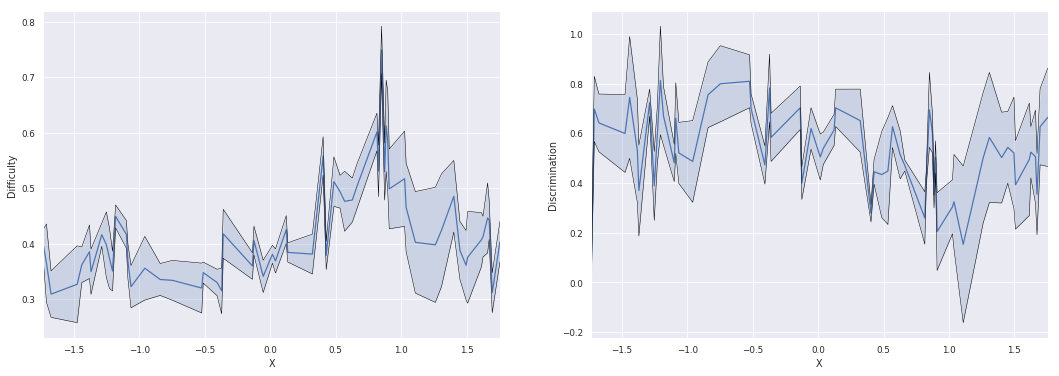

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i, param in enumerate(plot):
    x = X_test[Xsort_i].reshape(1,-1)[0]
    pmean = p_mean[Xsort_i, i][0]
    pstd = p_std[Xsort_i, i][0]
    
    axes[i].fill_between(x, y1 = pmean - 2*pstd, y2 = pmean + 2*pstd, alpha=0.2)
    axes[i].plot(x, pmean)
    axes[i].plot(x, pmean - 2*pstd, linewidth = 0.5, c='black')
    axes[i].plot(x, pmean + 2*pstd, linewidth = 0.5, c='black')
    axes[i].set_xlabel('X')
    axes[i].set_xlim([x[0], x[-1]])
    axes[i].set_ylabel(param)
plt.savefig('./Results_IRT/' + name + '/params_x.png')
plt.show()

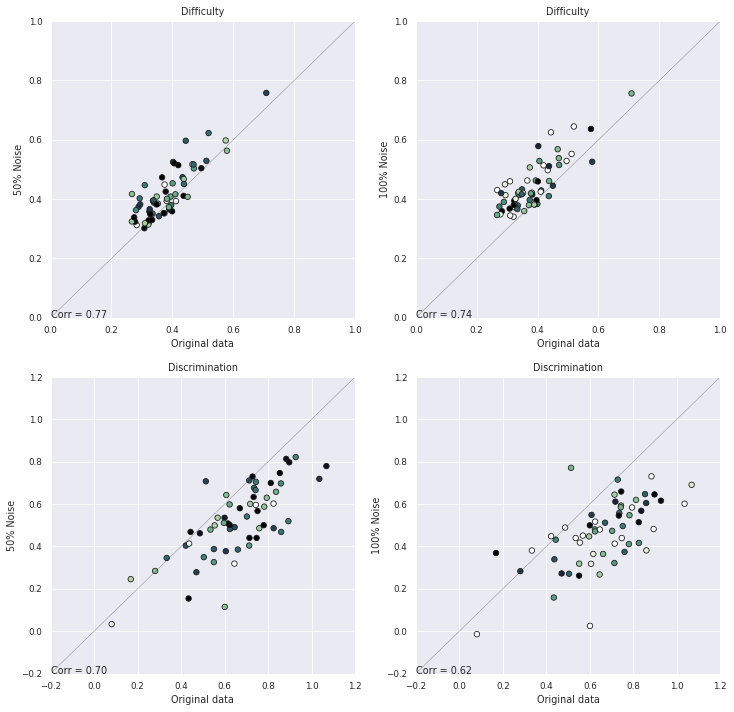

In [31]:
#Lower noise
scale = 0
fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i[1:]):
        if i == 0:
            lim = np.array([0,1])
        else:
            lim = np.array([-0.2, 1.2])
        
        axes[i,j].set_xlim(lim)
        axes[i,j].set_ylim(lim)
        axes[i,j].plot([lim[0],lim[1]], [lim[0], lim[1]], linewidth=0.2, c='black')        
        
        sns.set_context('paper')

        axes[i,j].text(x = lim[0], y = lim[0], s='Corr = %.2f' %(spearmanr(a = params[0][:, i], b = params[noise][:, i])[0]))
        axes[i, j].scatter(params[0][:, i], params[noise][:, i], c = noises[noise], cmap = cmap1, edgecolor='k',s=30)

        axes[i,j].set_xlabel("Original data")
        axes[i,j].set_ylabel(plts[j+1])
        axes[i,j].set_title(title)
fig.savefig('./Results_IRT/'+name+'/parameters.png')

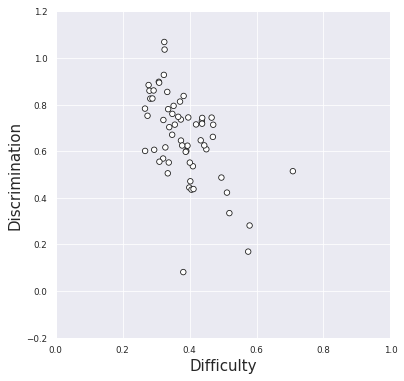

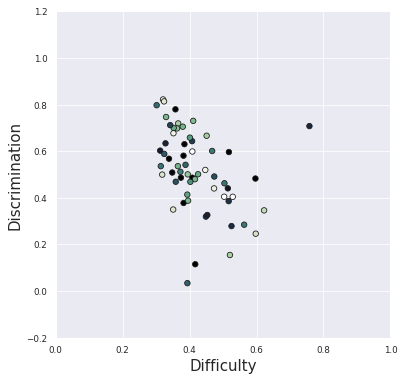

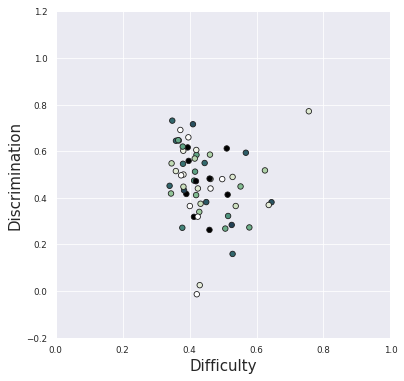

In [51]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[i])

    plt.scatter(params[noise][:,0], params[noise][:,1], c = c, cmap = cmap1, edgecolor='k',s=30)
#     plt.title(plts[i])
    plt.xlim([0,1])
    plt.ylim([-0.2, 1.2])
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Discrimination',fontsize=fsz)
    plt.savefig('./Results_IRT/'+name+'/dif_disc_' + str(noise))

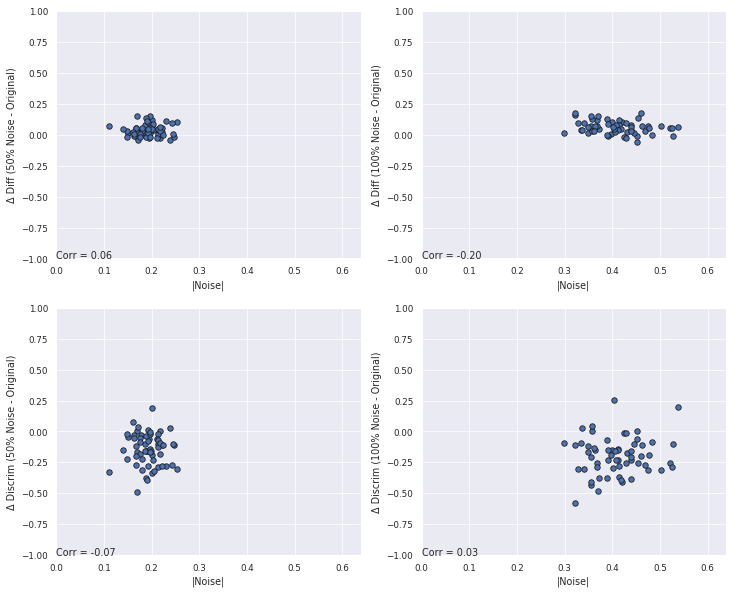

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for h, param in enumerate(['Diff', 'Discrim']):
    for i, noise in enumerate(noises_i[1:]):
        axes[h, i].scatter(noises[noise], (params[noise][:, h] - params[0][:, h]), edgecolor='k',s=30)
        axes[h, i].set_ylim([-1., 1.])
        axes[h, i].set_xlim([0, noises[-1].max() + 0.1])
        axes[h, i].text(x = 0, y = -1, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = (params[noise][:, h] - params[0][:, h]))[0]))

        axes[h, i].set_xlabel('|Noise|')
        axes[h, i].set_ylabel('Δ '+param+' ('+plts[i+1]+' - Original)')
fig.savefig('./Results_IRT/'+name+'/param_noise')

# Ability

In [34]:
abilities.shape

(13, 20)

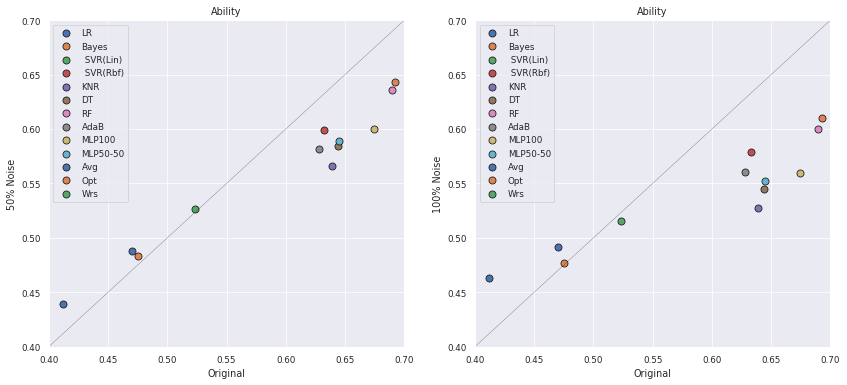

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
mdls = mdls = ['LR', 'Bayes', ' SVR(Lin)', ' SVR(Rbf)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP100', 'MLP50-50', 'Avg', 'Opt', 'Wrs']
lim = [0.4, 0.7]

for i, noise in enumerate(noises_i[1:]):
    for j, mdl in enumerate(mdls):
        axes[i].scatter(abilities[j, 0], abilities[j, noise], s = 50, label = mdl, edgecolor='k')
    axes[i].set_xlim(lim)
    axes[i].set_ylim(lim)
    axes[i].set_xlabel('Original')
    axes[i].set_ylabel(plts[i+1])
    axes[i].set_title('Ability')
    axes[i].plot(lim, lim, linewidth=0.2, c='black')
    axes[i].legend()
fig.savefig('./Results_IRT/'+name+'/ability')

# Error

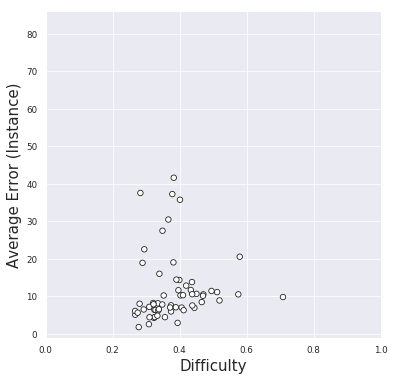

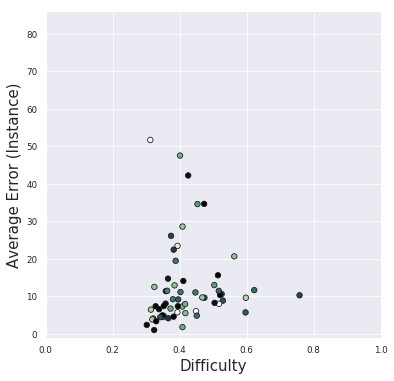

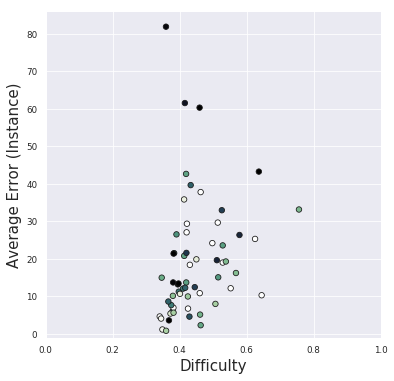

In [50]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[noise])
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    diff = params[noise][:, 0]
    plt.scatter(diff,mean_error, c= c, cmap = cmap1, edgecolor='k',s=30)
#     plt.text(x = 0, y = 0, s='Mean = %.2f Std = %.2f Corr = %.2f' %(mean_error.mean(), mean_error.std(), spearmanr(a = diff, b = mean_error)[0]), fontsize=10)
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Average Error (Instance)', fontsize=fsz)
    plt.xlim([0,1])
    plt.ylim([-1, 1.05*np.absolute(errors[-1]).mean(axis = 1).max()])
#     plt.title(plts[i])
    plt.savefig('./Results_IRT/'+name+'/diff_error_' + str(noise))

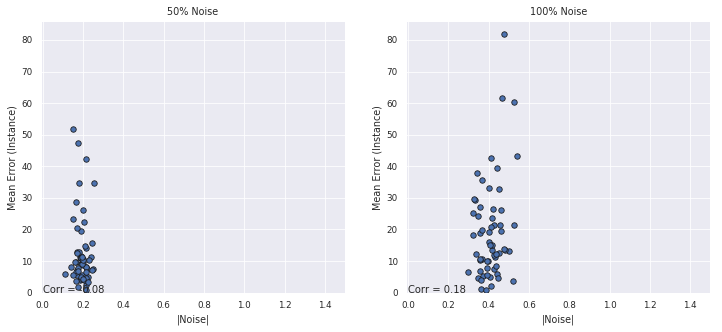

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, noise in enumerate(noises_i[1:]):
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    axes[i].scatter(noises[noise], mean_error, edgecolor='k',s=30)
    axes[i].text(x = 0, y = 0, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = mean_error)[0]), fontsize=10)
    axes[i].set_xlabel('|Noise|')
    axes[i].set_ylabel('Mean Error (Instance)')
    axes[i].set_xlim([-0.01, 1.5])
    axes[i].set_ylim([-0.1, 1.05*np.absolute(errors[-1]).mean(axis = 1).max()])
    axes[i].set_title(plts[i+1])
fig.savefig('./Results_IRT/'+name+'/noise_error')

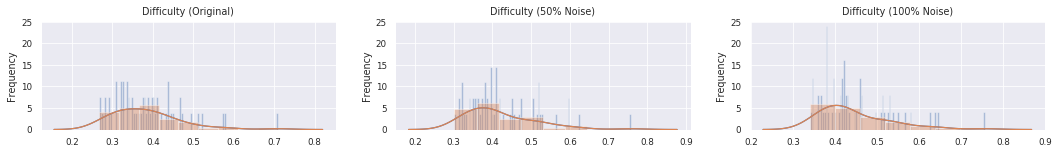

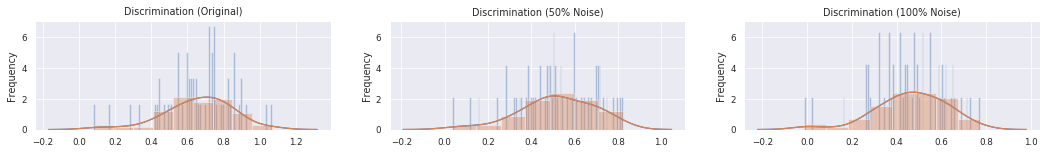

In [38]:
for h, param in enumerate(plot):
    sns.set_context('paper')
    scale = 0
    fig, axes = plt.subplots(1, 3, figsize=(18,2))
    for i, noise in enumerate(noises_i):
        values = params[noise][:, h]
        sns.distplot(values,bins=100,ax=axes[i])
        sns.distplot(values, ax= axes[i])
        current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
        if current_scale > scale:
            scale = current_scale
            y_lim = axes[i].get_ylim()
        axes[i].set_title(param + ' (' + plts[i] + ')')
        axes[i].set_ylabel('Frequency')
    for ax in axes:
        ax.set_ylim(y_lim)
    fig.subplots_adjust(hspace=0.3)
    fig.savefig('./Results_IRT/'+name+'/hists_' + param + '.png')

In [39]:
ind = np.lexsort((params[0,:,0], params[0,:,1]))

In [40]:
params[0, ind,:]

array([[0.38131867, 0.08077162],
       [0.57517217, 0.16862508],
       [0.57934795, 0.28069843],
       [0.5189638 , 0.333819  ],
       [0.51176889, 0.42197607],
       [0.40584091, 0.43461332],
       [0.41182903, 0.4371756 ],
       [0.39919284, 0.44372135],
       [0.4023692 , 0.47057559],
       [0.49513786, 0.48649413],
       [0.33498463, 0.50468824],
       [0.70856823, 0.51390304],
       [0.4099681 , 0.5351818 ],
       [0.40087433, 0.55077272],
       [0.33794264, 0.55110934],
       [0.30997826, 0.55460326],
       [0.32104052, 0.56824211],
       [0.38855835, 0.59707105],
       [0.3903038 , 0.60013888],
       [0.26727325, 0.60083098],
       [0.29436435, 0.60572544],
       [0.45016564, 0.6080151 ],
       [0.32776111, 0.61597905],
       [0.39381605, 0.62334089],
       [0.37804692, 0.62414003],
       [0.4439433 , 0.62463917],
       [0.37434389, 0.64534979],
       [0.43341198, 0.64625655],
       [0.46969261, 0.66114165],
       [0.34810367, 0.67025879],
       [0.

In [41]:
ind

array([ 0, 52, 10, 35, 22, 28, 29,  6, 18, 34, 14, 55, 47, 54, 44, 57, 19,
       51, 37, 17, 23, 12, 16,  1, 43, 33,  3, 40, 59, 49,  8, 36, 56, 31,
       42,  7, 48,  2, 45, 25, 20, 13, 50, 11, 30, 46, 26, 38,  4,  5, 27,
       58, 32, 53, 41, 39, 21,  9, 24, 15])

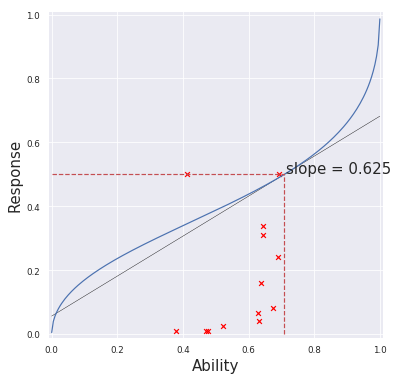

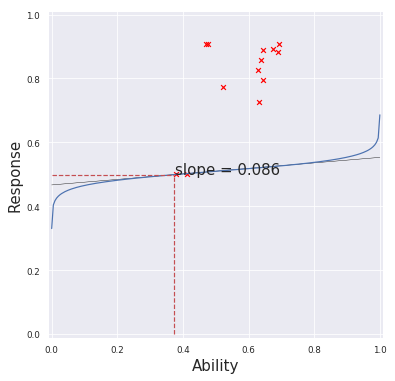

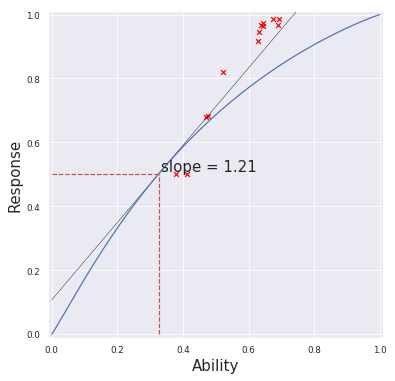

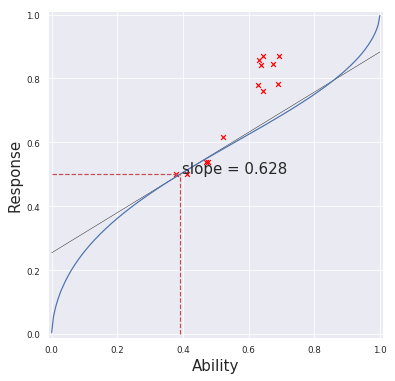

In [48]:
# +Diff+Disc/ -Diff-Disc/ -Diff+Disc/ +Diff-Disc
chosen_i = [55, 0, 15, 37]
ab = np.linspace(0.0001, 0.9999, 200)
sub_noise = ['Noise free', '50% Noise', '100% Noise']

for j in (chosen_i):
    plt.figure(figsize=(6, 6))
    par = params[0, j, :]
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=15)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities[:, 0], responses[0, j, :], marker= 'x', c = 'red')
    plt.ylabel('Response', fontsize=fsz)
    plt.xlabel('Ability', fontsize=fsz)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
#     plt.title('Instance ' + str(j))
#         plt.legend()
    plt.savefig('./Results_IRT/'+name+'/instance_' + str(j) + '.png')

In [ ]:
for i, noise in enumerate(noises_i):
    metrics = pd.DataFrame()
    metrics['Avg. Response'] = responses[noise][:, :-3].mean(axis = 0)
    metrics['Ability'] = abilities[:-3][noise]
    metrics['MAE'] = np.absolute(errors[i]).mean(axis = 0)
    metrics['MSE'] = (errors[]**2).mean(axis = 0)
    print(noise,'\n',metrics.corr(method = 'spearman'),'\n\n')